In [2]:
import numpy as np 
import pandas as pd
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import StandardScaler, normalize
from timeit import default_timer as timer
from collections import Counter
import matplotlib.pyplot as plt
import itertools

def load_data(filename):
    df = pd.read_csv("./data/" + filename)
    print(df.shape)
    if filename == "falldeteciton.csv":   
        X = df.iloc[:,1:]
        y = df.iloc[:,0] 
        print(sorted(df['ACTIVITY'].unique()))
    else:
        X = df.iloc[:,:-1]
        y = df.iloc[:,-1]
        print(sorted(df['target_class'].unique()))
    return X, y

def split_data(X, y, test_size):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10, test_size=test_size)
    return X_train, X_test, y_train, y_test

def normalize_data(X_train, X_test):
    sc = StandardScaler()
    X_train_scale = sc.fit_transform(X_train)
    X_test_scale = sc.transform(X_test)
    return X_train_scale, X_test_scale

#https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html#sphx-glr-auto-examples-model-selection-plot-learning-curve-py
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt
    
def cluster_predictions(y, cluster_labels):
    assert (y.shape == cluster_labels.shape)
    pred = np.empty_like(y)
    for label in set(cluster_labels):
        mask = cluster_labels == label
        sub = y[mask]
        target = Counter(sub).most_common(1)[0][0]
        pred[mask] = target   
    return pred

## Part 1: Clustering Algorithms 

In [3]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score as sil_score, f1_score
from sklearn.metrics.cluster import completeness_score, homogeneity_score, v_measure_score
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt

def kmeans_cluster(X,y,title):
    k_range = range(2, 16)
    scores = []; sil_scores = []; f1_scores = []; train_times = []

    for k in k_range:
        #print(k)
        start = timer()
        km = KMeans(n_clusters=k,init='random',n_init=10,n_jobs=-1).fit(X)
        end = timer()
        train_times.append(end - start)
        score = km.inertia_
        scores.append(score)   
        sil_scores.append(sil_score(X, km.labels_))
        y_mode_vote = cluster_predictions(y, km.labels_)
        f1_scores.append(f1_score(y, y_mode_vote, average='weighted'))
        
    # Plot scores
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(k_range, scores)
    plt.grid(True)
    plt.xlabel('No. Clusters')
    plt.ylabel('Inertia Score')
    plt.title('Elbow Plot for KMeans: '+ title)
    plt.show()
    
    # elbow curve for silhouette score
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(k_range, sil_scores)
    plt.grid(True)
    plt.xlabel('No. Clusters')
    plt.ylabel('Avg Silhouette Score')
    plt.title('Elbow Plot for KMeans: '+ title)
    plt.show()
   
    # plot f1 scores
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(k_range, f1_scores)
    plt.grid(True)
    plt.xlabel('No. Clusters')
    plt.ylabel('F1 Score')
    plt.title('F1 Scores KMeans: '+ title)
    plt.show()

    # plot model training time
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(k_range, train_times)
    plt.grid(True)
    plt.xlabel('No. Clusters')
    plt.ylabel('Training Time (s)')
    plt.title('KMeans Training Time: '+ title)
    plt.show()
    
def em_cluster(X,y,title):
    k_range = range(2, 16)
    aic_scores = []; bic_scores = []; sil_scores = []; f1_scores = []; train_times = []

    for k in k_range:
        start = timer()
        em = GaussianMixture(n_components=k,init_params='random',n_init=10,random_state=10).fit(X)
        end = timer()
        train_times.append(end - start)
        aic_score = em.aic(X)
        bic_score = em.bic(X)
        aic_scores.append(aic_score) 
        bic_scores.append(bic_score)
        labels = em.predict(X)
        sil_scores.append(sil_score(X, labels))
        y_mode_vote = cluster_predictions(y, labels)
        f1_scores.append(f1_score(y, y_mode_vote, average='weighted'))
        
    # plot AIC and BIC
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(k_range, aic_scores, label='AIC')
    ax.plot(k_range, bic_scores,label='BIC')
    plt.grid(True)
    plt.xlabel('No. Distributions')
    plt.ylabel('Model Complexity Score')
    plt.title('EM Model Complexity: '+ title)
    plt.legend(loc="best")
    plt.show()
    
    # elbow curve for silhouette score
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(k_range, sil_scores)
    plt.grid(True)
    plt.xlabel('No. Distributions')
    plt.ylabel('Avg Silhouette Score')
    plt.title('Elbow Plot for EM: '+ title)
    plt.show()
   
    # plot f1 scores
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(k_range, f1_scores)
    plt.grid(True)
    plt.xlabel('No. Distributions')
    plt.ylabel('F1 Score')
    plt.title('F1 Scores EM: '+ title)
    plt.show()

    # plot model training time
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(k_range, train_times)
    plt.grid(True)
    plt.xlabel('No. Distributions')
    plt.ylabel('Training Time (s)')
    plt.title('EM Training Time: '+ title)
    plt.show()
    
def kmeans_evaluate(X, y, n_comp):
    km = KMeans(n_clusters=n_comp, init='random', n_init=10, n_jobs=-1)
    start = timer()
    km.fit(X, y)
    end = timer()
    train_time = end - start
    #labels = km.fit_predict(X)
    
    print("No. of Components: {}".format(n_comp))
    print("Homogeneity: {0:.3f}".format(homogeneity_score(y, km.labels_)))
    print("Completeness: {0:.3f}".format(completeness_score(y, km.labels_)))
    print("V-measure: {0:.3f}".format(v_measure_score(y, km.labels_)))
    
    y_mode_vote = cluster_predictions(y, km.labels_)
    accuracy = accuracy_score(y, y_mode_vote)
    precision = precision_score(y, y_mode_vote, average="weighted")
    recall = recall_score(y, y_mode_vote, average="weighted")
    cm = confusion_matrix(y, y_mode_vote)

    print("Model Evaluation Metrics Using Mode Cluster Vote")
    print("*****************************************************")
    print("Model Training Time (s):   "+"{:.2f}".format(train_time))
    print("No. Iterations to Converge: {}".format(km.n_iter_))
    print("Accuracy:  "+"{:.2f}".format(accuracy))
    print("Precision: "+"{:.2f}".format(precision)+"     Recall:    "+"{:.2f}".format(recall))
    print("*****************************************************")
    
def em_evaluate(X, y, n_comp):
    em = GaussianMixture(n_components=k,init_params='random',n_init=10,random_state=10)
    start = timer()
    em.fit(X, y)
    end = timer()
    train_time = end - start
    labels = em.predict(X)
    
    print("No. of Distributions: {}".format(n_comp))
    print("Homogeneity: {0:.3f}".format(homogeneity_score(y, labels)))
    print("Completeness: {0:.3f}".format(completeness_score(y, labels)))
    print("V-measure: {0:.3f}".format(v_measure_score(y, labels)))
    
    y_mode_vote = cluster_predictions(y, labels)
    accuracy = accuracy_score(y, y_mode_vote)
    precision = precision_score(y, y_mode_vote, average="weighted")
    recall = recall_score(y, y_mode_vote, average="weighted")
    cm = confusion_matrix(y, y_mode_vote)

    print("Model Evaluation Metrics Using Mode Cluster Vote")
    print("*****************************************************")
    print("Model Training Time (s):   "+"{:.2f}".format(train_time))
    print("No. Iterations to Converge: {}".format(km.n_iter_))
    print("Accuracy:  "+"{:.2f}".format(accuracy))
    print("Precision: "+"{:.2f}".format(precision)+"     Recall:    "+"{:.2f}".format(recall))
    print("*****************************************************")

(17898, 9)
[0, 1]


/Users/SQZZ/miniconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


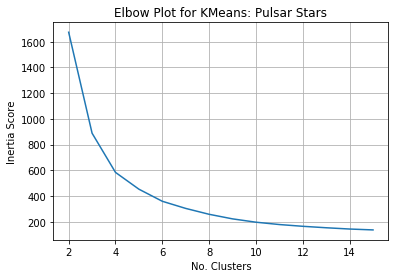

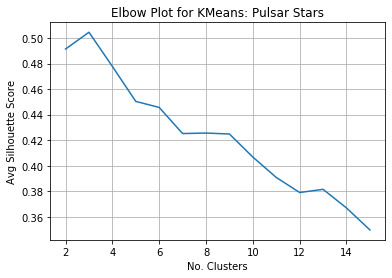

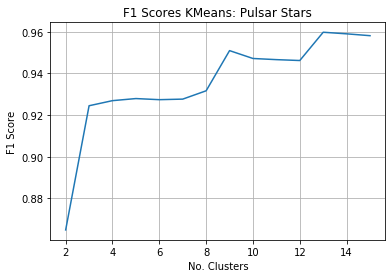

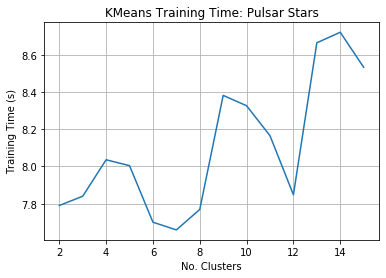

In [4]:
filename = "pulsar_stars.csv"
#filename = "falldeteciton.csv"
X, y = load_data(filename)
X = normalize(X)
kmeans_cluster(X,y,'Pulsar Stars')
#kmeans_evaluate(X,y,3)
#kmeans_evaluate(X,y,4)